# Task
The task consists of analysing the dataset for individual household electric power consumption
available here. The questions are relatively open ended to allow you to decide on your own
what would be the most effective technique to solve the challenge. Suppose the end customer is
a power utility company which wishes to use these insights to offer better plans to their
customers as well as better manage their grid based on customer usage patterns.
1. Download and process the data into a pandas Dataframe.
2. Visualize the data. It’s a very large dataset, how can we plot it in a way that a human
understands its main features?
3. Using a clustering method, identify different power usage patterns of the household.
4. Using a time series regression method, predict the next month’s consumption patterns.
5. Using publicly available data, estimate the GHG Scope 2 emissions of the household on
a monthly basis.
6. Assuming a hypothetical grid where generated power is mostly renewables during the
day, and fossil fuels at night, identify potential changes to the household’s patterns to
minimize its GHG emissions.

In [ ]:
!pip install statsmodels --upgrade --quiet
!pip install pmdarima --quiet
!pip install skforecast --quiet

     |████████████████████████████████| 9.8 MB 4.7 MB/s 
     |████████████████████████████████| 1.4 MB 5.6 MB/s 
     |████████████████████████████████| 87 kB 3.2 MB/s 
     |████████████████████████████████| 9.8 MB 12.8 MB/s 
     |████████████████████████████████| 76 kB 2.8 MB/s 


## Libraries

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle, islice

# matplotlib style
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 6)

# Timeseries

from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.tsa.seasonal import DecomposeResult
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm


from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import matplotlib as mpl
import lightgbm as lgb

# Warnings configuration
import warnings
warnings.filterwarnings('ignore')

# Warnings

import warnings
warnings.filterwarnings('ignore')

# 1.  Proccessing Data 

In [ ]:
drive.mount('/content/gdrive')
df = pd.read_csv('/content/gdrive/MyDrive/recursive/electric_consumption/household_power_consumption.txt',sep=";")


# combine data and time
df['date_time'] = df['Date'] + ' ' + df['Time']
df['date_time'] = pd.to_datetime(df['date_time'], format='%d/%m/%Y %H:%M:%S')
df = df.drop(columns=['Date','Time'],axis=1)
df = df.set_index('date_time')

# convert object cols to numeric
cols = df.columns[df.dtypes.eq('object')]
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

Mounted at /content/gdrive


### missing data

In [ ]:
df.isnull().sum() # interpolate fill instead ?
df = df.fillna(method="bfill")

### Initial data visualization ( more in depth data visualization below)

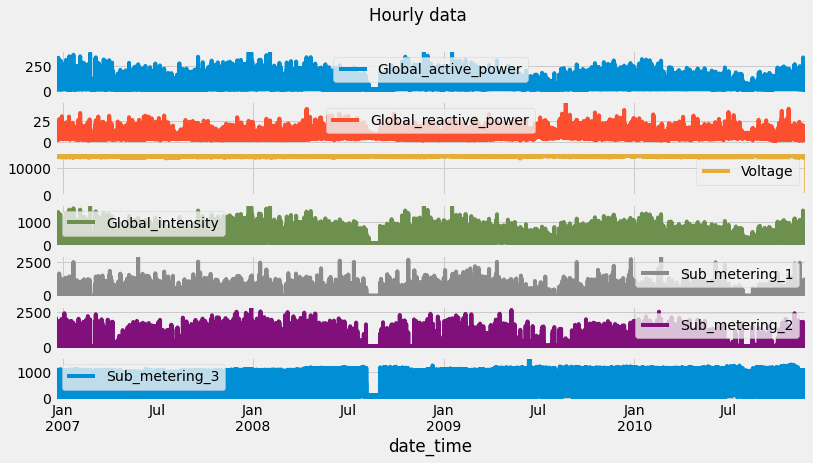

In [ ]:
df.resample('H').sum().plot(title='Hourly data', subplots=True)
plt.show()

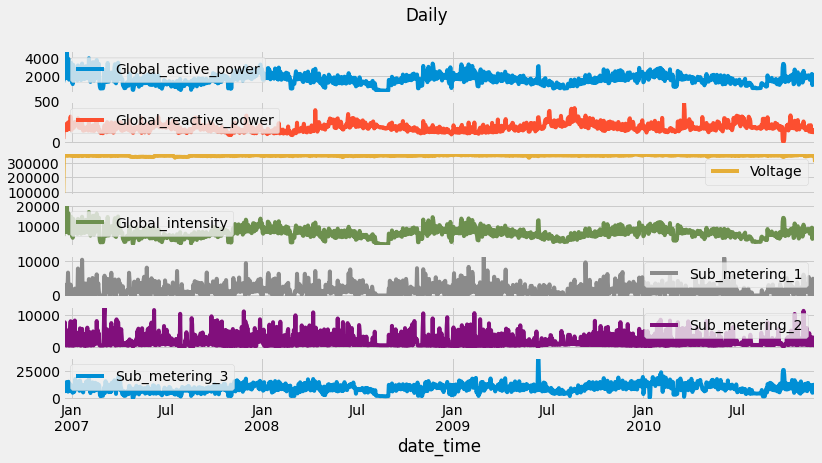

In [ ]:
df.resample('D').sum().plot(title='Daily',subplots=True)
plt.show()

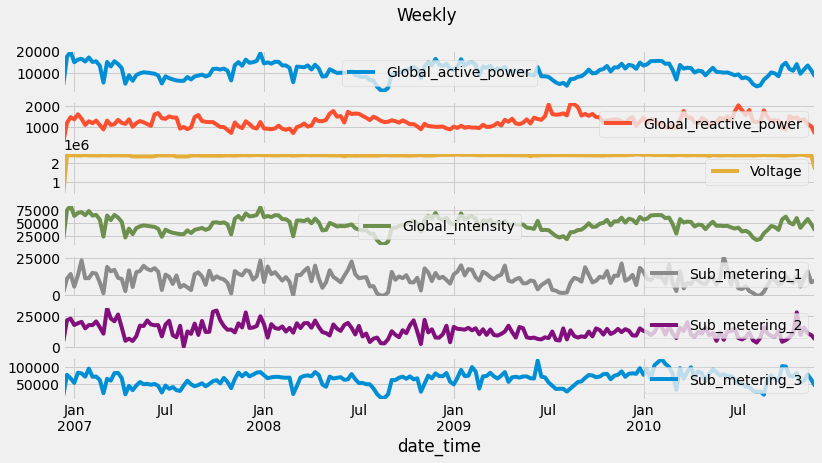

In [ ]:
df.resample('W').sum().plot(title='Weekly',subplots=True)
plt.show()

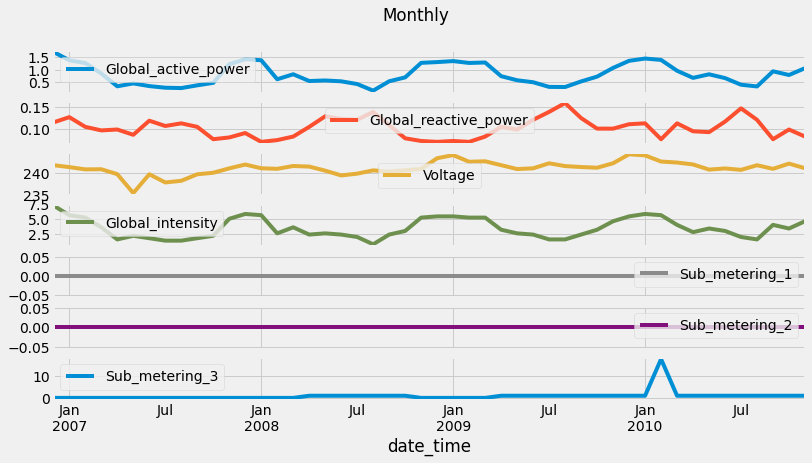

In [ ]:
df.resample('M').median().plot(title='Monthly',subplots=True)
plt.show()

## Subset dataset to only active power

This is done because the electricity the household actively consumed is under active power

In [ ]:
global_active_df = df[['Global_active_power']]

## Initial Feature Engineering

In [ ]:
# Creating a weekend flag
global_active_df["Day of Week"] = global_active_df.index.dayofweek
global_active_df["Is_Weekend"] = global_active_df["Day of Week"] > 4

# 2. Visualize household patterns

We will visualize household electric consumption patterns monthly, weekly, daily and hourly

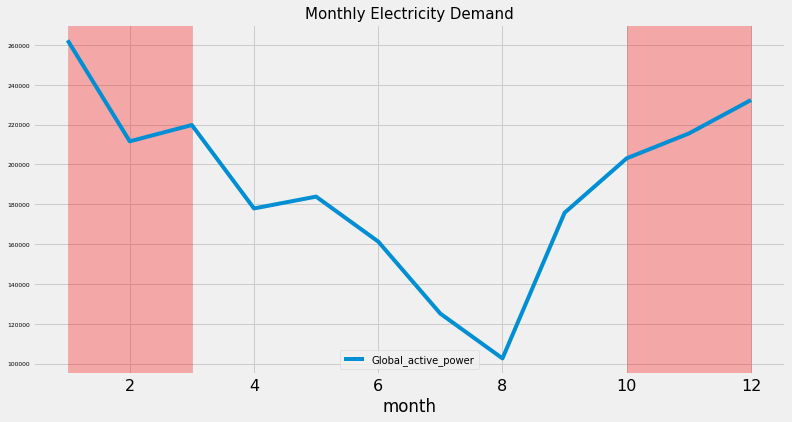

In [ ]:
index_month = global_active_df.index.month
mean_active_power_levels_by_month = global_active_df.groupby(index_month).sum() 
ax = mean_active_power_levels_by_month['Global_active_power'].plot(fontsize=6)

plt.title('Monthly Electricity Demand', fontsize=15)
plt.legend(fontsize=10)
plt.xticks(fontsize=16)
plt.xlabel('month')
ax.axvspan(1, 3, color='red', alpha=0.3)
ax.axvspan(10, 12, color='red', alpha=0.3)

# Show plot
plt.show()

As monthly electricity peaks during colder months and decreases during warmer months

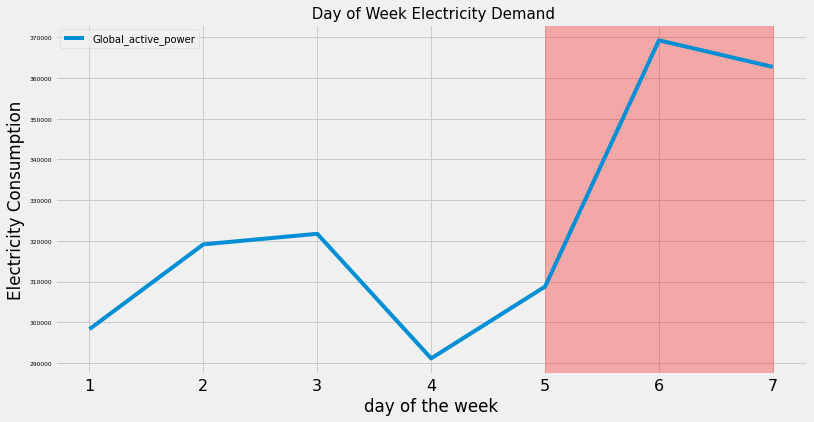

In [ ]:
index_day = global_active_df.index.day_of_week + 1
mean_active_power_levels_by_day = global_active_df.groupby(index_day).sum() 
ax = mean_active_power_levels_by_day['Global_active_power'].plot(fontsize=6)

# Specify the fontsize on the legend
plt.title(' Day of Week Electricity Demand', fontsize=15)
plt.legend(fontsize=10)
plt.xticks(fontsize=16)
plt.ylabel('Electricity Consumption')
plt.xlabel('day of the week')
ax.axvspan(5, 7, color='red', alpha=0.3)

plt.show()

Weekends (Including Fridays is when electricity consumptions peaks)

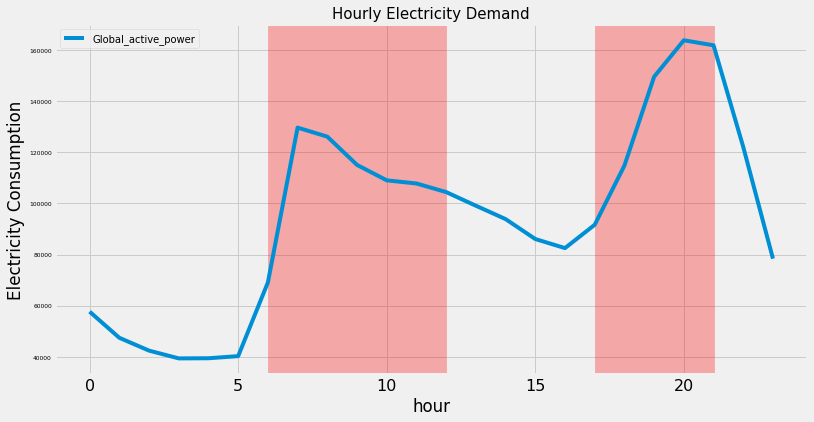

In [ ]:
index_hour = global_active_df.index.hour 
mean_active_power_levels_by_hour = global_active_df.groupby(index_hour).sum() 
ax = mean_active_power_levels_by_hour['Global_active_power'].plot(fontsize=6)

plt.title('Hourly Electricity Demand', fontsize=15)
plt.legend(fontsize=10)
plt.xticks(fontsize=16)
plt.ylabel('Electricity Consumption')
plt.xlabel('hour')
ax.axvspan(6, 12, color='red', alpha=0.3)
ax.axvspan(17, 21, color='red', alpha=0.3)

plt.show()

We can see electricity consumption rises during working hours, decreases after (presumably) as they are away from home and increases during the night

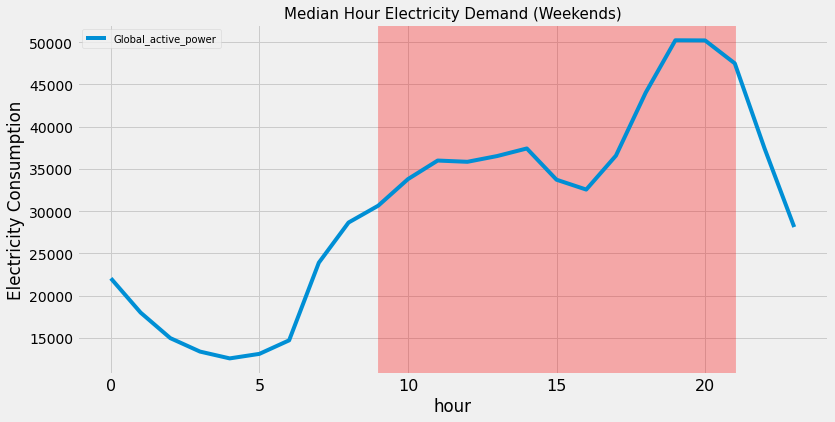

In [ ]:
weekend_global_active = global_active_df[global_active_df["Is_Weekend"] == True]
index_hour = weekend_global_active.index.hour 
mean_active_power_levels_by_hour = weekend_global_active.groupby(index_hour).sum() 
ax = mean_active_power_levels_by_hour['Global_active_power'].plot()# Specify the fontsize on the legend

plt.title('Hour Electricity Demand (Weekends)', fontsize=15)
plt.legend(fontsize=10)
plt.xticks(fontsize=16)
plt.ylabel('Electricity Consumption')
plt.xlabel('hour')
ax.axvspan(9, 21, color='red', alpha=0.3)

plt.show()

During the weekends however, it continues to rise throughout the day and peaks during the night

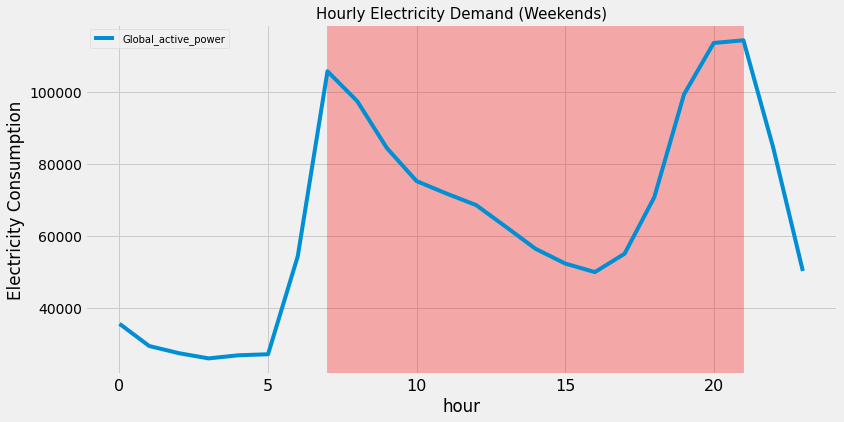

In [ ]:
weekend_global_active = global_active_df[global_active_df["Is_Weekend"] == False]
index_hour = weekend_global_active.index.hour 
mean_active_power_levels_by_hour = weekend_global_active.groupby(index_hour).sum()
ax = mean_active_power_levels_by_hour['Global_active_power'].plot()# Specify the fontsize on the legend

plt.title('Hourly Electricity Demand (Weekends)', fontsize=15)
plt.legend(fontsize=10)
plt.xticks(fontsize=16)
plt.ylabel('Electricity Consumption')
plt.xlabel('hour')
ax.axvspan(7, 21, color='red', alpha=0.3)

plt.show()

Incontrast to weekdays where we see the usual pattern

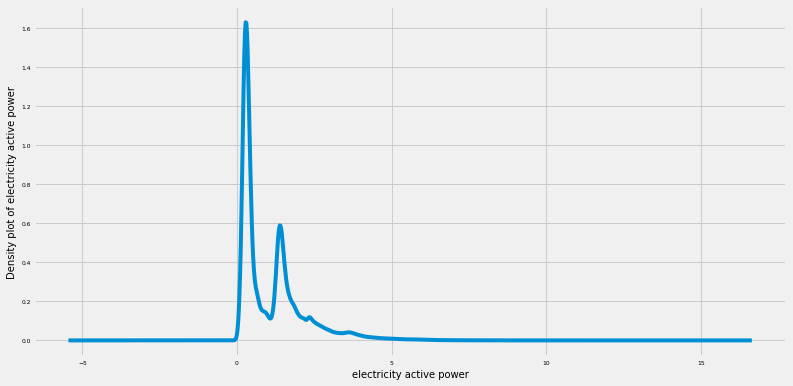

In [ ]:
# density plot
ax = global_active_df['Global_active_power'].plot(kind='density', linewidth=4, fontsize=6)
ax.set_xlabel('electricity active power', fontsize=10)
ax.set_ylabel('Density plot of electricity active power', fontsize=10)

plt.show()

In [ ]:
global_active_df.replace({False: 0, True: 1}, inplace=True)

###Aggregating Timeseries


In [ ]:
hourly_active_power_df = global_active_df[['Global_active_power']].resample('H').sum()
daily_active_power_df = global_active_df[['Global_active_power']].resample('D').sum()
weekly_active_power_df = global_active_df[['Global_active_power']].resample('W').sum()
monthly_active_power_df = global_active_df[['Global_active_power']].resample('M').sum()

### Weekend vs Non Weekend

In [ ]:
hourly_active_power_df["Day of Week"] = hourly_active_power_df.index.dayofweek
hourly_active_power_df["Is_Weekend"] = hourly_active_power_df["Day of Week"] > 4

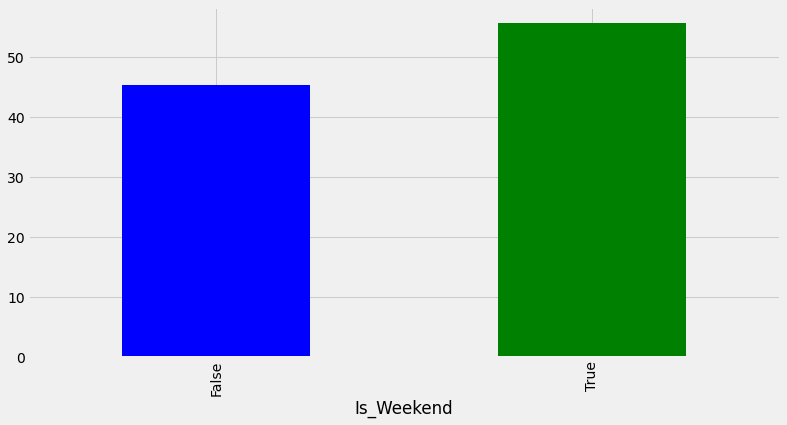

In [ ]:
my_colors = list(islice(cycle(['b', 'g']), None, len(df)))
hourly_active_power_df.groupby('Is_Weekend')['Global_active_power'].median().plot(kind='bar',color=my_colors)

This supports the previous visualization where electricity consumption tends to be higher during the weekend

### Zooming in

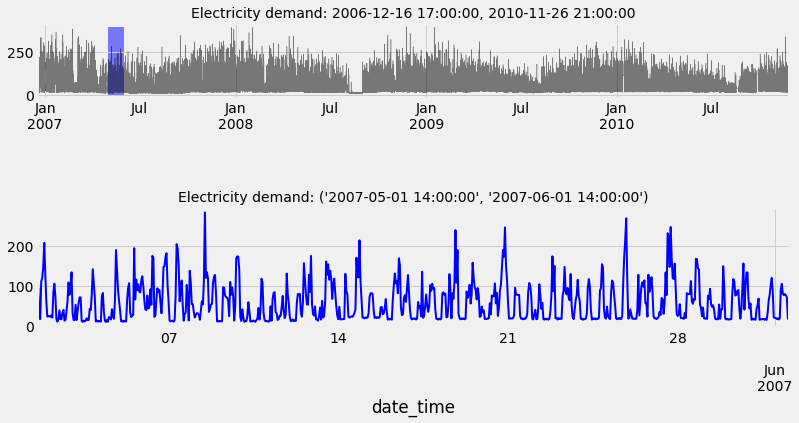

In [ ]:
# Zooming time series chart
# ==============================================================================
zoom = ('2007-05-01 14:00:00','2007-06-01 14:00:00')

fig = plt.figure(figsize=(12, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

hourly_active_power_df.Global_active_power.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(hourly_active_power_df.Global_active_power)
max_y = max(hourly_active_power_df.Global_active_power)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')

hourly_active_power_df.loc[zoom[0]: zoom[1]].Global_active_power.plot(ax=zoom_ax, color='blue', linewidth=2)

main_ax.set_title(f'Electricity demand: {hourly_active_power_df.index.min()}, {hourly_active_power_df.index.max()}', fontsize=14)
zoom_ax.set_title(f'Electricity demand: {zoom}', fontsize=14)
plt.subplots_adjust(hspace=1)

### Seasonal Decomposition

Seasonal decomposition breaks down our time series to trend, seasonal and white noise components

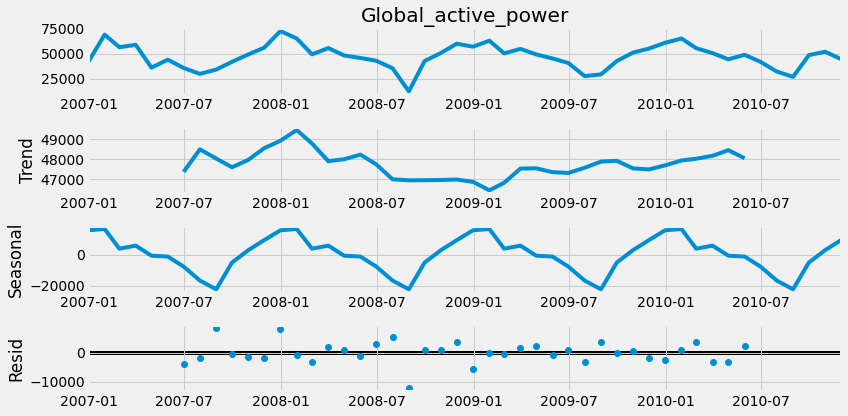

In [ ]:
# Perform time series decompositon
decomposition = sm.tsa.seasonal_decompose(monthly_active_power_df['Global_active_power'])
fig = decomposition.plot()
plt.show()

We see a clear annual seasonality where it peaks during certain months(winter season) and falls back down during warmer seasons

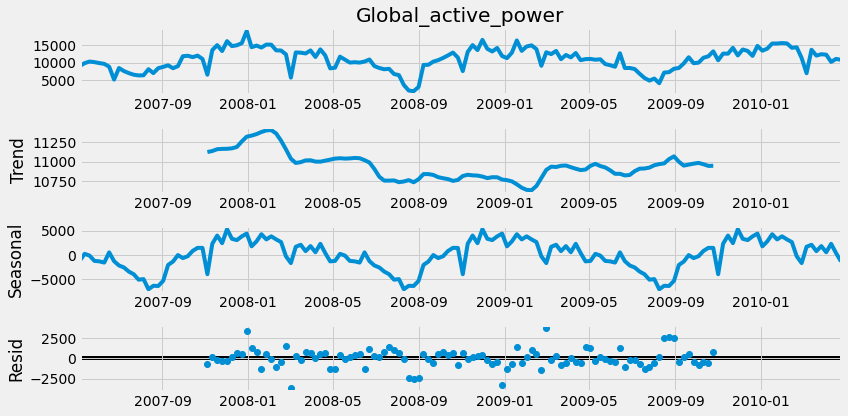

In [ ]:
zoomed_weekly = weekly_active_power_df.loc["2007-05-01":"2010-05-01"]
decomposition = sm.tsa.seasonal_decompose(zoomed_weekly['Global_active_power'])
fig = decomposition.plot()
plt.show()

We also see monthly seasonality but its harder to understand the patterns..

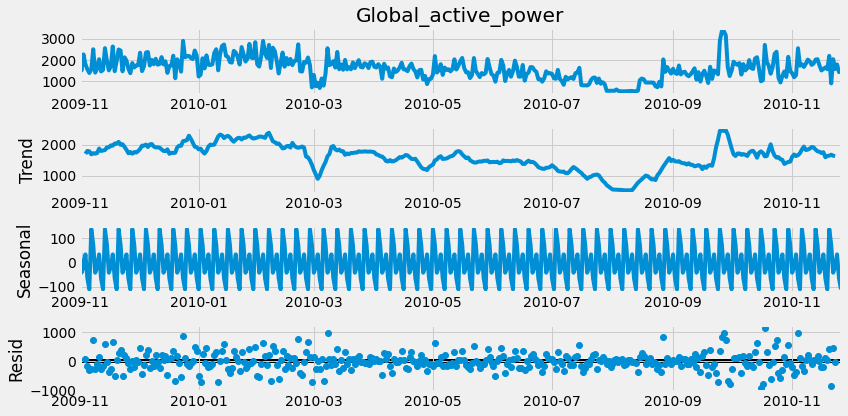

In [ ]:
zoomed_daily = daily_active_power_df.loc["2009-11-01":"2010-11-26"]
decomposition = sm.tsa.seasonal_decompose(zoomed_daily['Global_active_power'])
fig = decomposition.plot()
plt.show()

We can also see weekly seasonality where it peaks during certain days of the week, presumably weekends which is consitent with out previous visualization

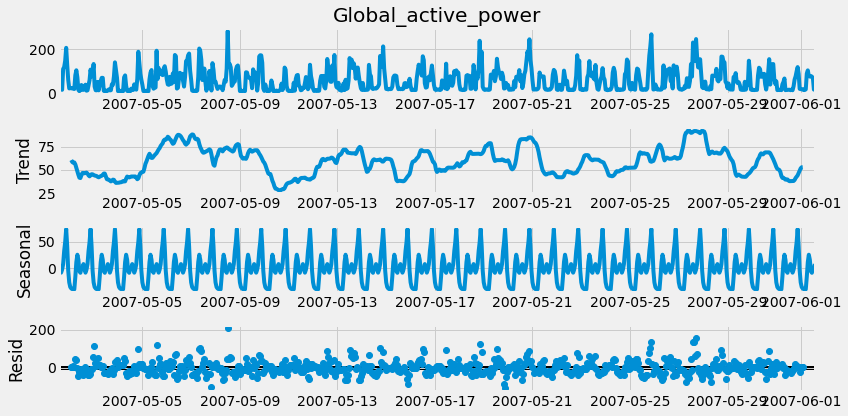

In [ ]:
zoomed_hourly = hourly_active_power_df.loc["2007-05-01 14:00:00":"2007-06-01 14:00:00'"]
decomposition = sm.tsa.seasonal_decompose(zoomed_hourly['Global_active_power'])
fig = decomposition.plot()
plt.show()

Finally we see daily seasonality where it peaks during certain days of waking hours and the evening

By slicing or series to shorter intervals we can see monthly, weekly, daily and seasonality. We are dealing with complex seasonality

# 3. Clustering
https://towardsdatascience.com/clustering-electricity-profiles-with-k-means-42d6d0644d00

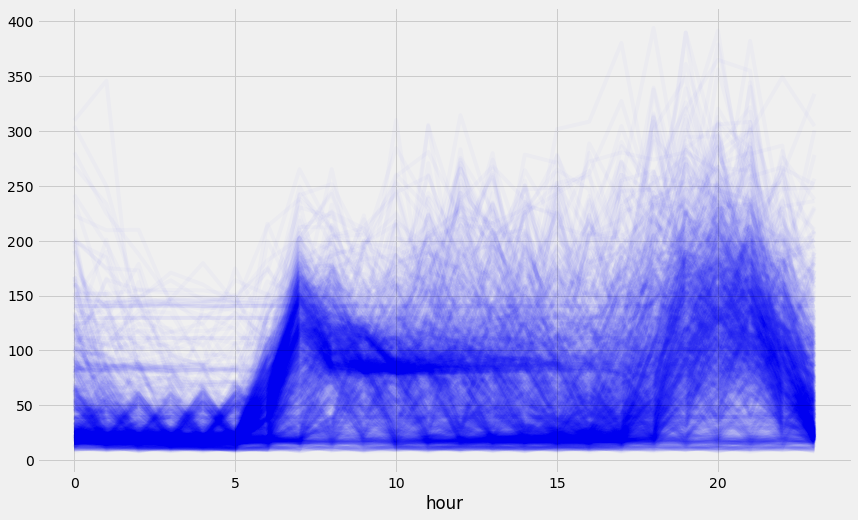

In [ ]:
hour_df = hourly_active_power_df[['Global_active_power']]

hour_df['hour'] = hour_df.index.hour
hour_df.index = hour_df.index.date

df_uci_pivot = hour_df.pivot(columns='hour')
df_uci_pivot = df_uci_pivot.dropna()
df_uci_final = df_uci_pivot.T.reset_index(level=[0,1])

df_uci_final.plot(legend=False,x='hour',color='blue',alpha=0.02,figsize=(13,8))

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

sillhoute_scores = []
n_cluster_list = np.arange(2,31).astype(int)

X = df_uci_pivot.values.copy()
    
# Very important to scale!
sc = MinMaxScaler()
X = sc.fit_transform(X)

for n_cluster in n_cluster_list:
    
    kmeans = KMeans(n_clusters=n_cluster)
    cluster_found = kmeans.fit_predict(X)
    sillhoute_scores.append(silhouette_score(X, kmeans.labels_))

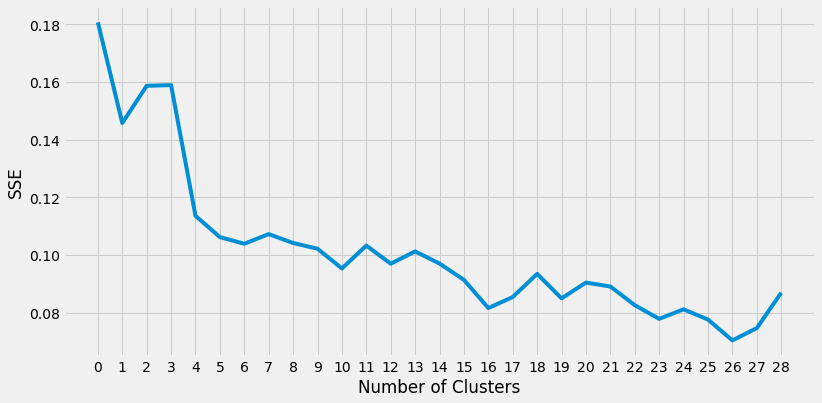

In [ ]:
plt.plot(range(len(n_cluster_list)), sillhoute_scores)
plt.xticks(range(len(n_cluster_list)))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

based on our plot, 3 seems to be the ideal number of clusters 

Text(0.5, 0, 'hour')

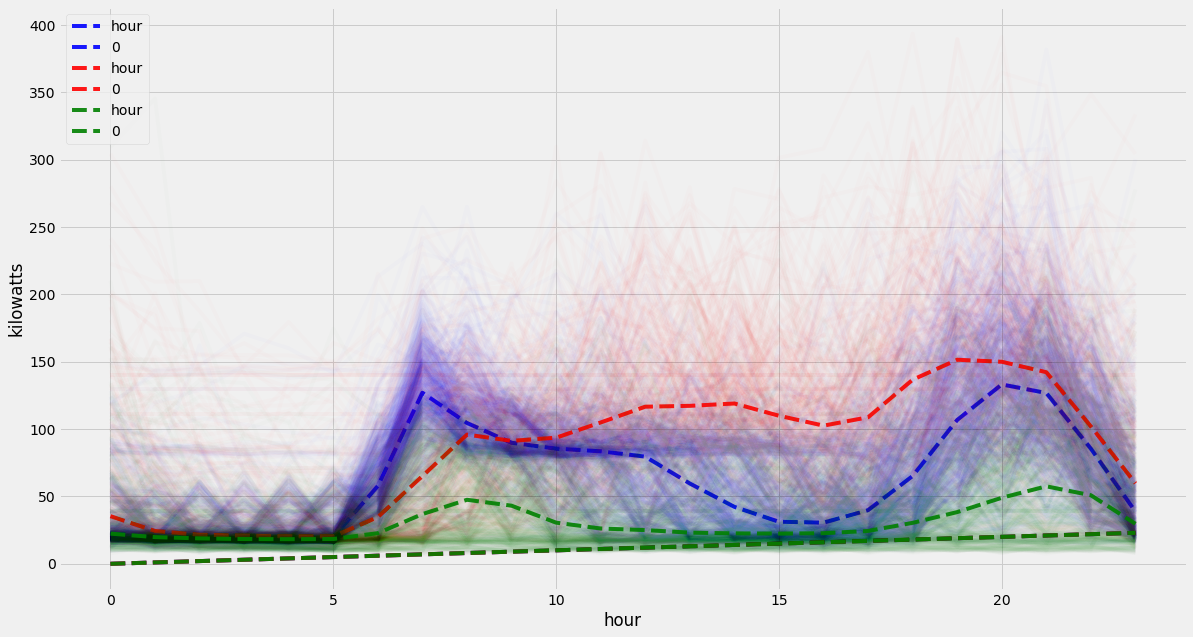

In [ ]:
kmeans = KMeans(n_clusters=3)
cluster_found = kmeans.fit_predict(X)
cluster_found_sr = pd.Series(cluster_found, name='cluster')
df_uci_pivot = df_uci_pivot.set_index(cluster_found_sr, append=True )

fig, ax= plt.subplots(1,1, figsize=(18,10))
color_list = ['blue','red','green']
cluster_values = sorted(df_uci_pivot.index.get_level_values('cluster').unique())
color_list = ['blue','red','green']
cluster_values = sorted(df_uci_pivot.index.get_level_values('cluster').unique())
cols =list(df_uci_pivot.columns.values)
cols_hour = [v for k, v in cols]
for cluster, color in zip(cluster_values, color_list):
    df_uci_pivot.xs(cluster, level=1).T.reset_index().plot(
        ax=ax, legend=False, alpha=0.01, color=color, label= f'Cluster {cluster}'
        )
    df_uci_pivot.xs(cluster, level=1).median().reset_index().plot(
        ax=ax, color=color, alpha=0.9, ls='--'
    )

ax.set_ylabel('kilowatts')
ax.set_xlabel('hour')

Based on our 3 clusters:
* Blue line seems to be weekday patterns where it peaks during the waking hours and when they are home
* Red line seems to be weekend patterns where it continiously rises throught the day or when days they are home all day
* The green line could be week day pattenrs during summer months where the electric consumptions is signficantly lower 

# 4. Regression

2 methods will be used, SARIMA and Xgboost
The better model will the be used to predict 1 month ahead

### Plot ACF and PACF

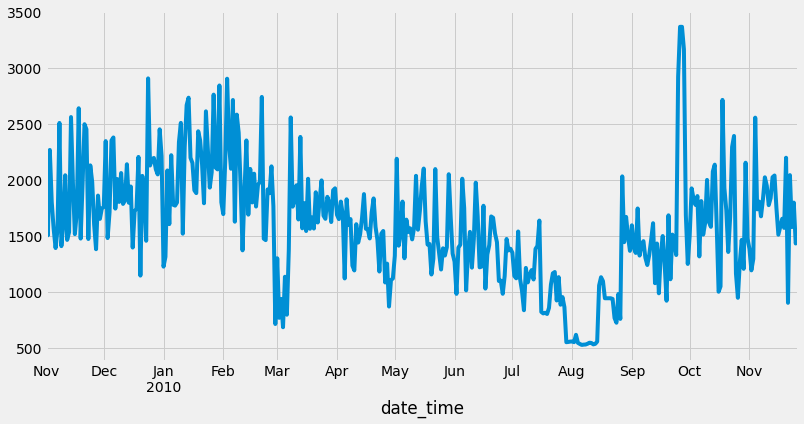

In [ ]:
zoomed_daily['Global_active_power'].plot()

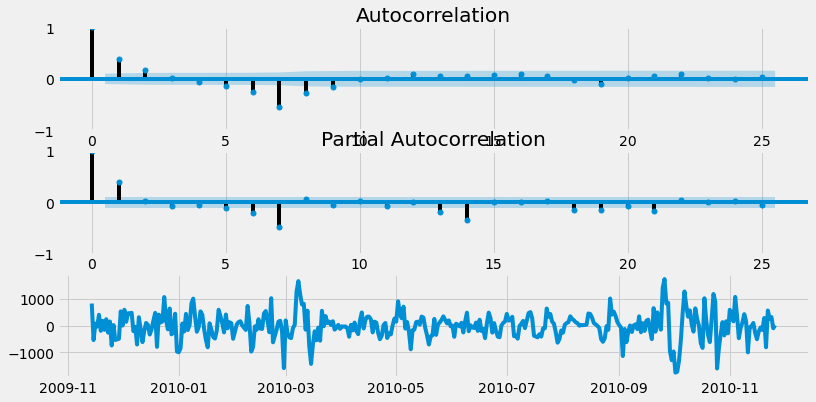

In [ ]:
detrend_zoomed_daily = zoomed_daily['Global_active_power'] - zoomed_daily['Global_active_power'].rolling(7).mean()
x = (detrend_zoomed_daily.dropna() - detrend_zoomed_daily.dropna().shift(7)).dropna()

fig, ax = plt.subplots(3, figsize=(12,6))
ax[0] = plot_acf(x, ax=ax[0], lags=25)
ax[1] = plot_pacf(x, ax=ax[1], lags=25)
ax[2].plot(x)


In [ ]:
# Split data into train-val-test
# ==============================================================================
data = daily_active_power_df.loc["2007-05-01":]
end_train = '2010-10-28' 
data_train = data.loc[: end_train, :]
data_test  = data.loc[end_train:, :]


print(f"Train dates       : {data_train.index.min()} --- {data_train.index.max()}")
print(f"Test dates        : {data_test.index.min()} --- {data_test.index.max()}")
print("Train data amount :", data_train.shape[0])
print("Test data amount  :", data_test.shape[0])
print("Test percentage   : ",round((data_test.shape[0] /data_train.shape[0] * 100),1),'%')

Train dates       : 2007-05-01 00:00:00 --- 2010-10-28 00:00:00
Test dates        : 2010-10-28 00:00:00 --- 2010-11-26 00:00:00
Train data amount : 1277
Test data amount  : 30
Test percentage   :  2.3 %


In [ ]:
model1 = pm.auto_arima(data_train['Global_active_power'],
                      seasonal=True, m=7,
                 	  max_p=3, max_q=3,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True)
                       
# Print model summary
print(model1.summary()) #93 aic

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=5.48 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=19795.296, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=18999.436, Time=1.23 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=19199.885, Time=1.28 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=22522.242, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=19115.758, Time=0.09 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=18928.124, Time=5.83 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=18949.729, Time=8.11 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=18998.843, Time=2.63 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=19754.402, Time=3.97 sec
 ARIMA(2,0,0)(2,0,0)[7] intercept   : AIC=18918.008, Time=5.77 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=18970.464, Time=2.50 sec
 ARIMA(2,0,0)(2,0,1)[7] intercept   : AIC=18920.145, Time=8.29 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=18960.290, Time=4.01 sec
 ARIMA(3,0,0)(2,0,0)[7] i

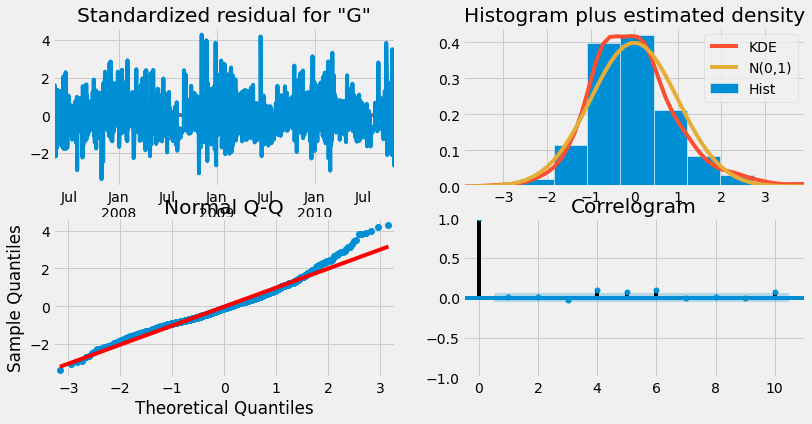

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Create model object
model = SARIMAX(data_train['Global_active_power'], 
                order=(3, 0, 0),  
                seasonal_order=(2, 0, 1, 7), 
                trend='c')
# Fit model
results = model.fit()

results.plot_diagnostics()
plt.show()

In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                 Global_active_power   No. Observations:                 1277
Model:             SARIMAX(3, 0, 0)x(2, 0, [1], 7)   Log Likelihood               -9430.460
Date:                             Mon, 11 Jul 2022   AIC                          18876.921
Time:                                     09:47:57   BIC                          18918.139
Sample:                                 05-01-2007   HQIC                         18892.400
                                      - 10-28-2010                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    320.5550     60.614      5.288      0.000     201.754     439.356
ar.L1          0.4049      0.023     17.958      0.000       0.361       0.449
ar.L2          0.0531      0.028      1.900      0.057      -0.002       0.108
ar.L3          0.1394      0.026      5.268      0.000       0.088       0.191
ar.S.L7        0.3228      0.115      2.795      0.005       0.096       0.549
ar.S.L14       0.1715      0.040      4.330      0.000       0.094       0.249
ma.S.L7       -0.1375      0.120     -1.148      0.251      -0.372       0.097
sigma2      1.504e+05   4974.241     30.232      0.000    1.41e+05     1.6e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):               196.34
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.65
Prob(H) (two-sided):                  0.39   Kurtosis:                         4.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Create forecast object
#forecast_object = results.get_forecast(steps=4) # forecast_object = results.get_prediction(-200)
forecast_object = results.get_prediction(-600)

# Extract prediction mean
mean = forecast_object.predicted_mean

# Extract the confidence intervals
conf_int = forecast_object.conf_int()

# Extract the forecast dates
dates = mean.index

### Backcasting

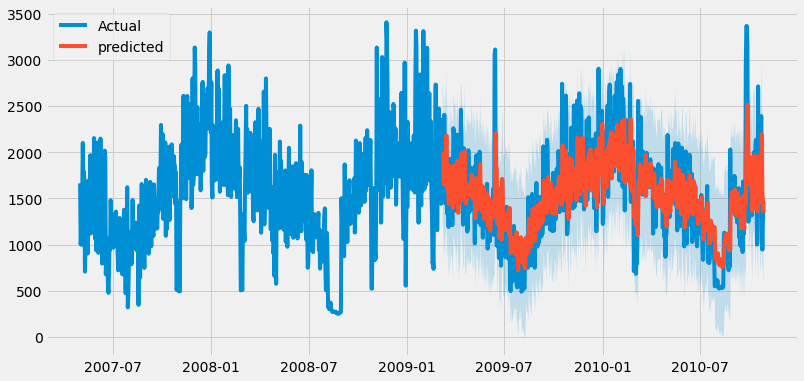

In [ ]:
plt.figure()
plt.plot(data_train.index, data_train['Global_active_power'], label='Actual')
plt.plot(dates, mean, label='predicted')
plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.2)

# Plot legend and show figure
plt.legend()
plt.show()

In [ ]:
mae = np.mean(np.abs(results.resid))
print(mae)

297.88665873994495


In [ ]:
# Create forecast object
forecast_object = results.get_forecast(steps=29) # forecast_object = results.get_prediction(-200)
#forecast_object = results.get_prediction(-100)

# Extract prediction mean
mean = forecast_object.predicted_mean

# Extract the confidence intervals
conf_int = forecast_object.conf_int()

# Extract the forecast dates
dates = mean.index

test = data_test[['Global_active_power']]
forecast = mean.to_frame()
forecast['actual'] = test['Global_active_power'] 
forecast['error'] = round(abs((forecast['actual']  - forecast['predicted_mean'])),2)
forecast['percentage_error'] = (forecast['error'] /forecast['actual']) * 100
forecast[['actual','predicted_mean','error','percentage_error']]

,actual,predicted_mean,error,percentage_error
2010-10-29,1204.422,1397.059570,192.64,15.994394
2010-10-30,2152.700,1447.251428,705.45,32.770474
2010-10-31,1476.430,1538.157214,61.73,4.181031
2010-11-01,1383.180,1650.894877,267.71,19.354675
2010-11-02,1191.082,1472.810614,281.73,23.653283
2010-11-03,1293.298,1518.735501,225.44,17.431404
2010-11-04,2555.146,1496.798114,1058.35,41.420334
2010-11-05,1736.088,1538.437208,197.65,11.384792
2010-11-06,1805.408,1661.197852,144.21,7.987668
2010-11-07,1673.816,1704.411703,30.60,1.828158


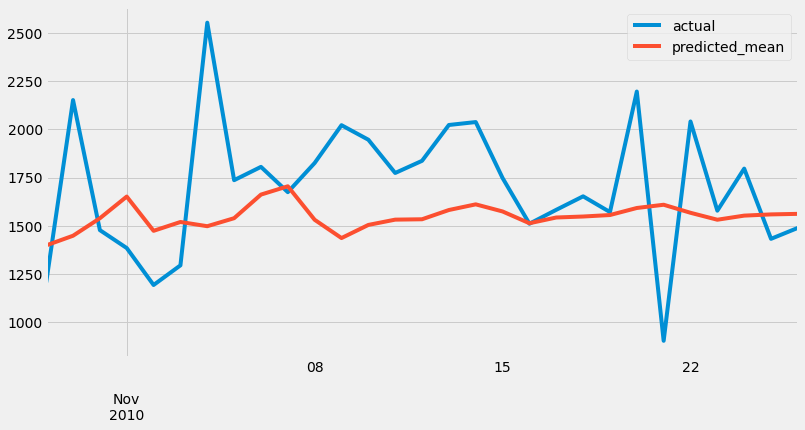

In [ ]:
actual_plot = forecast['actual'].plot()
predicted_plot = forecast['predicted_mean'].plot()
plt.legend()
plt.show()

In [ ]:
print('MAPE score is :', round(forecast['percentage_error'].mean(),2)

17.13

The forecast seems good when we did backcasting and looking at the MAE,
but when we forecast it looks equivalent to a naive forecast after a few time steps

# Daily forecast with xgboost

In [ ]:
# Split data into train-val-test
# ==============================================================================
data = daily_active_power_df.loc["2007-05-01":]
end_train = '2010-10-28' 
data_train = data.loc[: end_train, :]
data_test  = data.loc[end_train:, :]


print(f"Train dates       : {data_train.index.min()} --- {data_train.index.max()}")
print(f"Test dates        : {data_test.index.min()} --- {data_test.index.max()}")
print("Train data amount :", data_train.shape[0])
print("Test data amount  :", data_test.shape[0])
print("Test percentage   : ",round((data_test.shape[0] /data_train.shape[0] * 100),1),'%')

Train dates       : 2007-05-01 00:00:00 --- 2010-10-28 00:00:00
Test dates        : 2010-10-28 00:00:00 --- 2010-11-26 00:00:00
Train data amount : 1277
Test data amount  : 30
Test percentage   :  2.3 %


In [ ]:
df_training = data_train
df_test = data_test
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

1277 days of training data 
 30 days of testing data 


In [ ]:
def create_time_features(df, target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [ ]:
X_train_df, y_train = create_time_features(
    df_training, target='Global_active_power')
X_test_df, y_test = create_time_features(df_test, target='Global_active_power')
scaler = StandardScaler()
scaler.fit(X_train_df)  # No cheating, never scale on the training+test!
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

## Xgboost

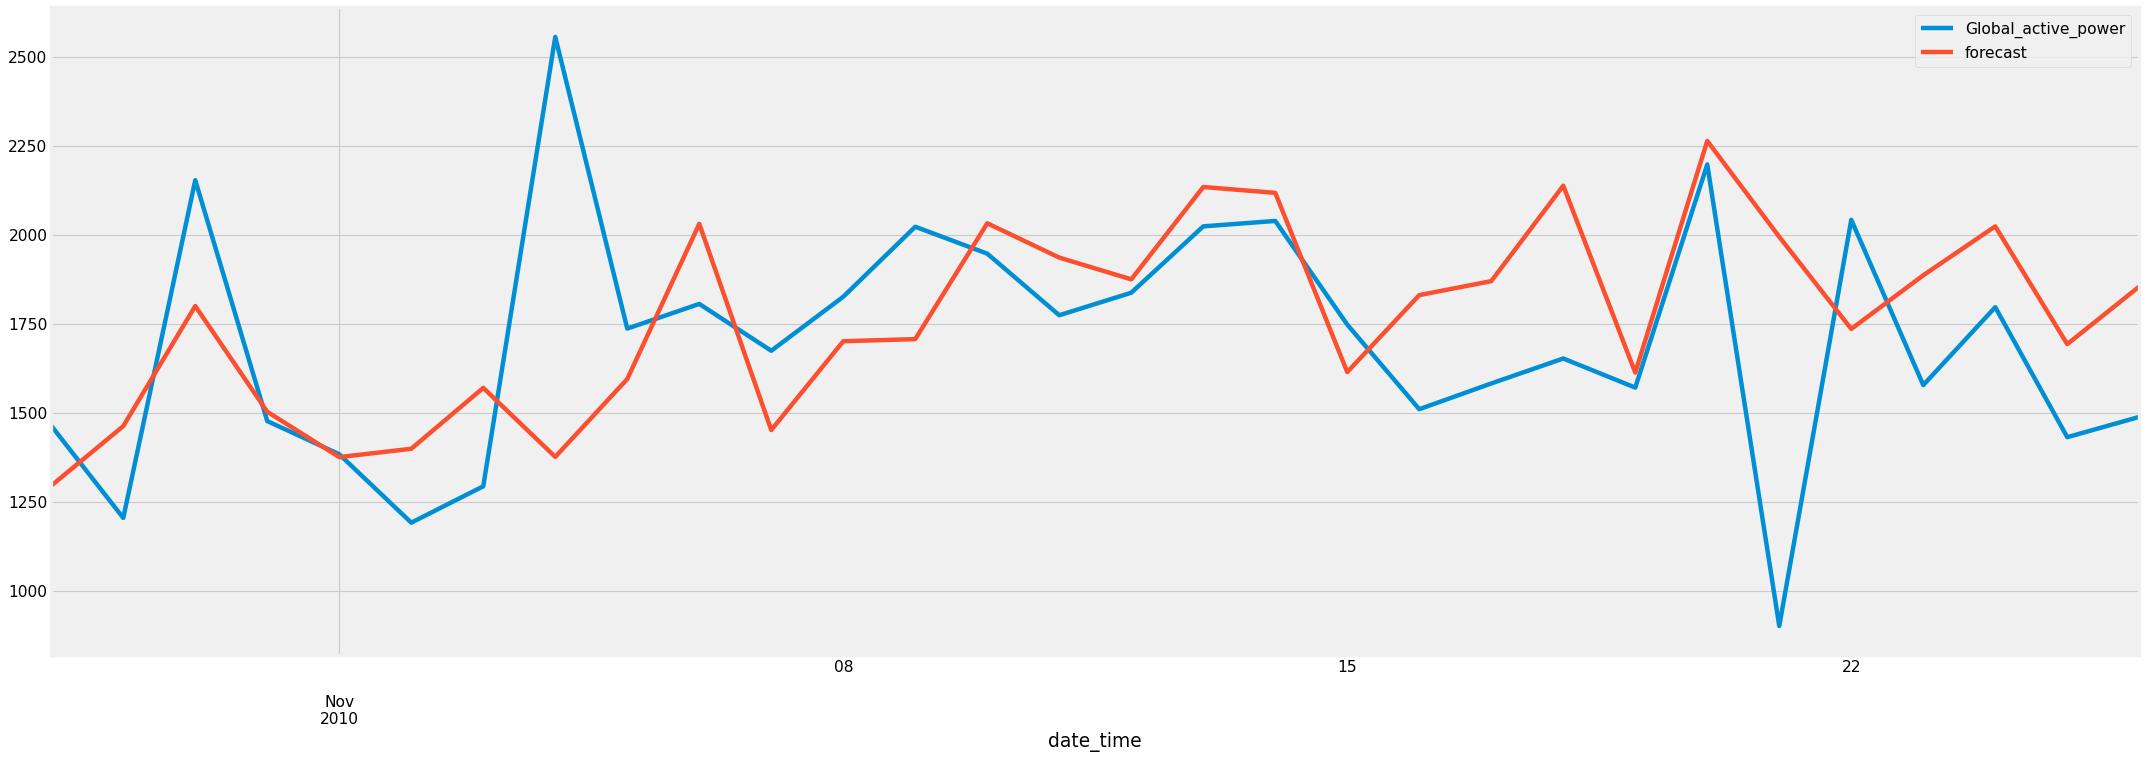

MAPE of model is :  17.05 %


In [ ]:
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=5000)
xgb_reg.fit(X_train, y_train,
        verbose=False)  # Change verbose to True if you want to see it train
yhat = xgb_reg.predict(X_test)

# Results
result_df = y_test.to_frame()
forecast = pd.Series(yhat) 
result_df = result_df.assign(forecast = yhat)
result_df['error'] = round(abs((result_df['Global_active_power']  - result_df['forecast'])),2)
result_df['percentage_error'] = round((result_df['error'] /result_df['Global_active_power']) * 100,1)

# plot
plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
actual_plot = result_df['Global_active_power'].plot()
predicted_plot = result_df['forecast'].plot()
plt.legend()
plt.show()
print('MAPE of model is : ',round(result_df['percentage_error'].mean(),2),'%')

In [ ]:
result_df

,Global_active_power,forecast,error,percentage_error
date_time,,,,
2010-10-28,1463.326,1294.934692,168.39,11.5
2010-10-29,1204.422,1462.239502,257.82,21.4
2010-10-30,2152.700,1799.441895,353.26,16.4
2010-10-31,1476.430,1502.505859,26.08,1.8
2010-11-01,1383.180,1375.183472,8.00,0.6
2010-11-02,1191.082,1398.655884,207.57,17.4
2010-11-03,1293.298,1569.641724,276.34,21.4
2010-11-04,2555.146,1375.917847,1179.23,46.2
2010-11-05,1736.088,1594.498657,141.59,8.2


The forecast is same as our SARIMA forecast but but it actually captures the pattern

# 4b.Predicting 1 month ahead
 out of sample/ next month prediction

In [ ]:
oos_data  = pd.date_range(start='2010-11-26', end='2010-12-26', freq='D') # creating our own data for next month
oos_data = oos_data.to_frame()
oos_data = create_time_features(oos_data)
oos_data = oos_data.drop(columns=[0],axis=1)
oos_data_scaled = scaler.transform(oos_data)
yhat_oos = xgb_reg.predict(oos_data_scaled)

# Future forecast
next_month = pd.Series(yhat_oos)
oos_data = oos_data.assign(forecast = yhat_oos)
oos_data[['forecast']]

,forecast
2010-11-26,1854.223633
2010-11-27,2051.777588
2010-11-28,2214.098145
2010-11-29,1720.743652
2010-11-30,1865.110718
2010-12-01,2091.517578
2010-12-02,1835.128418
2010-12-03,1621.761108
2010-12-04,2199.517090
2010-12-05,2214.199707


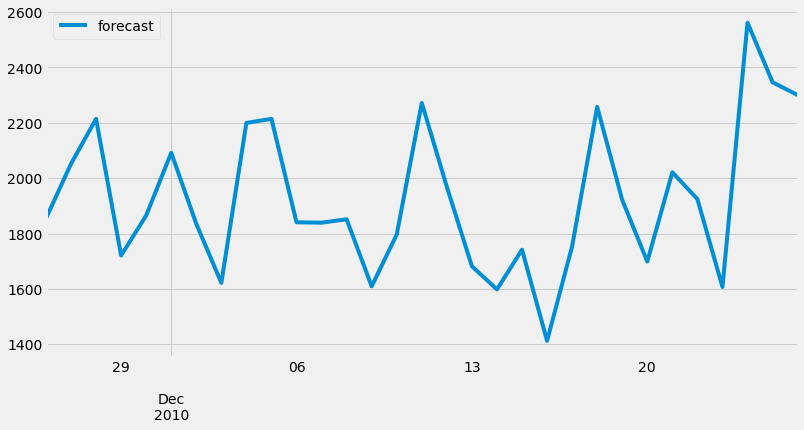

In [ ]:
oos_data[['forecast']].plot()

#5. Estimating Monthly emissions:

Data is a french household

* In 2006 greenhouse gas emission from France was 0.101kgCO2e
* In 2007 greenhouse gas emission from France was 0.096kgCO2e
* In 2008 greenhouse gas emission from France was 0.087kgCO2e
* In 2009 greenhouse gas emission from France was 0.079kgCO2e
* In 2010 greenhouse gas emission from France was 0.077kgCO2e


For electricity, the calculation will be (household consumption kWh) x (ghg emission at particular year)kgCO2e ÷ 1,000 = (result)tCO2e

source of data : https://www.eea.europa.eu/data-and-maps/indicators/overview-of-the-electricity-production-3/assessment

In [ ]:
Monthly_consumption = df[['Global_active_power']].resample('M').sum() / 60

In [ ]:
Monthly_consumption['date'] = Monthly_consumption.index
Monthly_consumption['month'] = Monthly_consumption['date'].dt.month
Monthly_consumption['year'] = Monthly_consumption['date'].dt.year

In [ ]:
Monthly_consumption = Monthly_consumption.groupby(by=['year','month']).sum().reset_index()

# assigning emission based on year
Monthly_consumption.loc[Monthly_consumption['year'] == 2006, 'emission'] = 0.101
Monthly_consumption.loc[Monthly_consumption['year'] == 2007, 'emission'] = 0.096
Monthly_consumption.loc[Monthly_consumption['year'] == 2008, 'emission'] = 0.087
Monthly_consumption.loc[Monthly_consumption['year'] == 2009, 'emission'] = 0.079
Monthly_consumption.loc[Monthly_consumption['year'] == 2010, 'emission'] = 0.077

In [ ]:
Monthly_consumption['monthly_household_ghg_emission(tCO2e)'] = Monthly_consumption['Global_active_power'] * Monthly_consumption['emission'] /1000

In [ ]:
Monthly_consumption

,year,month,Global_active_power,emission,monthly_household_ghg_emission(tCO2e)
0,2006,12,697.123433,0.101,0.070409
1,2007,1,1150.289367,0.096,0.110428
2,2007,2,941.644633,0.096,0.090398
3,2007,3,981.047800,0.096,0.094181
4,2007,4,600.753367,0.096,0.057672
5,2007,5,733.481200,0.096,0.070414
6,2007,6,595.779233,0.096,0.057195
7,2007,7,497.404733,0.096,0.047751
8,2007,8,569.004700,0.096,0.054624
9,2007,9,698.063500,0.096,0.067014


#6. Better energy allocation

Assuming a hypothetical grid where generated power is mostly renewables during the day, and fossil fuels at night, identify potential changes to the household’s patterns to minimize its GHG emissions.

Depending the flexibility we have:

1. We can first use fossil fuels during summer months and renewable energies during colder months
2. Switch patterns. instead use fossil fuels during the day and renewable energy during the night
3. Use fossil fuels during weekdays and renewable energy during weekends